# Phenolopy

## Initialise phenolopy

### Load packages

In [1]:
%matplotlib inline
%load_ext autoreload

import os, sys
import xarray as xr
import numpy as np
import pandas as pd
import datacube
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter, wiener
from scipy.stats import zscore
from statsmodels.tsa.seasonal import STL as stl
from datacube.drivers.netcdf import write_dataset_to_netcdf

sys.path.append('../Scripts')
from dea_datahandling import load_ard
from dea_dask import create_local_dask_cluster
from dea_plotting import display_map, rgb

sys.path.append('./scripts')
import phenolopy

/env/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


### Set up a dask cluster

In [2]:
# initialise the cluster. paste url into dask panel for more info.
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:35847 Dashboard: /user/lewis/proxy/8787/status,Cluster Workers: 1 Cores: 2 Memory: 13.11 GB


In [3]:
# open up a datacube connection
dc = datacube.Datacube(app='phenolopy')

## Study area and data setup

### Set study area and time range

In [4]:
# set lat, lon (y, x) dictionary of testing areas for gdv project
loc_dict = {
    'test_a':   (-23.28043, 119.85931),
    'test_b':   (-31.60693, 116.94264)
}

# set buffer length and height (x, y)
buff_dict = {
    'test_a': (0.05, 0.05),
    'test_b': (0.05, 0.05),
}

In [5]:
# select location from dict
study_area = 'test_a'

# set buffer size in lon, lat (x, y)
lon_buff, lat_buff = buff_dict[study_area][0], buff_dict[study_area][1]

# select start and end year range. for one year, set same year -01 for start and -12 for end. multiple years will be averaged. 
time_range = ('2016', '2020')

In [6]:
# select a study area from existing dict
lat, lon = loc_dict[study_area][0], loc_dict[study_area][1]

# combine centroid with buffer to form study boundary
lat_extent = (lat - lat_buff, lat + lat_buff)
lon_extent = (lon - lon_buff, lon + lon_buff)

# display onto interacrive map
display_map(x=lon_extent, y=lat_extent)

### Load sentinel-2a, b data for above parameters

In [7]:
# set measurements (bands)
measurements = [
    'nbart_blue',
    'nbart_green',
    'nbart_red',
    'nbart_nir_1',
    'nbart_swir_2'
]

# create query from above and expected info
query = {
    'x': lon_extent,
    'y': lat_extent,
    'time': time_range,
    'measurements': measurements,
    'output_crs': 'EPSG:3577',
    'resolution': (-10, 10),
    'group_by': 'solar_day',
}

# load sentinel 2 data
ds = load_ard(
    dc=dc,
    products=['s2a_ard_granule', 's2b_ard_granule'],
    min_gooddata=0.90,
    dask_chunks={'time': 1},
    **query
)

# display dataset
print(ds)

/home/jovyan/Phenolopy/../Tools/dea_tools/datahandling.py:237: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can slow the return of your dataset.
  warnings.warn("Setting 'min_gooddata' percentage to > 0.0 "


Finding datasets
    s2a_ard_granule
    s2b_ard_granule
Counting good quality pixels for each time step
Filtering to 188 out of 244 time steps with at least 90.0% good quality pixels
Applying pixel quality/cloud mask
Returning 188 time steps as a dask array
<xarray.Dataset>
Dimensions:       (time: 188, x: 1115, y: 1211)
Coordinates:
  * time          (time) datetime64[ns] 2016-02-19T02:06:40.376000 ... 2020-1...
  * y             (y) float64 -2.562e+06 -2.562e+06 ... -2.574e+06 -2.574e+06
  * x             (x) float64 -1.234e+06 -1.234e+06 ... -1.222e+06 -1.222e+06
    spatial_ref   int32 3577
Data variables:
    nbart_blue    (time, y, x) float32 dask.array<chunksize=(1, 1211, 1115), meta=np.ndarray>
    nbart_green   (time, y, x) float32 dask.array<chunksize=(1, 1211, 1115), meta=np.ndarray>
    nbart_red     (time, y, x) float32 dask.array<chunksize=(1, 1211, 1115), meta=np.ndarray>
    nbart_nir_1   (time, y, x) float32 dask.array<chunksize=(1, 1211, 1115), meta=np.ndarray>
    n

### Conform DEA band names

In [8]:
# takes our dask ds and conforms (renames) bands
ds = phenolopy.conform_dea_band_names(ds)

# display dataset
print(ds)

Conforming satellite bands
> Satellite band names conformed successfully.

<xarray.Dataset>
Dimensions:      (time: 188, x: 1115, y: 1211)
Coordinates:
  * time         (time) datetime64[ns] 2016-02-19T02:06:40.376000 ... 2020-12...
  * y            (y) float64 -2.562e+06 -2.562e+06 ... -2.574e+06 -2.574e+06
  * x            (x) float64 -1.234e+06 -1.234e+06 ... -1.222e+06 -1.222e+06
    spatial_ref  int32 3577
Data variables:
    blue         (time, y, x) float32 dask.array<chunksize=(1, 1211, 1115), meta=np.ndarray>
    green        (time, y, x) float32 dask.array<chunksize=(1, 1211, 1115), meta=np.ndarray>
    red          (time, y, x) float32 dask.array<chunksize=(1, 1211, 1115), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 1211, 1115), meta=np.ndarray>
    swir1        (time, y, x) float32 dask.array<chunksize=(1, 1211, 1115), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref


### Calculate vegetation index

In [9]:
# takes our dask ds and calculates veg index from spectral bands
ds = phenolopy.calc_vege_index(ds, index='mavi', drop=True)

# display dataset
print(ds)

Generating vegetation index: mavi
> Drop bands set to True. Dropping these bands: ['blue', 'green', 'red', 'nir', 'swir1']
> Vegetation index calculated successfully.

<xarray.Dataset>
Dimensions:      (time: 188, x: 1115, y: 1211)
Coordinates:
  * time         (time) datetime64[ns] 2016-02-19T02:06:40.376000 ... 2020-12...
  * y            (y) float64 -2.562e+06 -2.562e+06 ... -2.574e+06 -2.574e+06
  * x            (x) float64 -1.234e+06 -1.234e+06 ... -1.222e+06 -1.222e+06
    spatial_ref  int32 3577
Data variables:
    veg_index    (time, y, x) float32 dask.array<chunksize=(1, 1211, 1115), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref


## Pre-processing phase

### Group data by month and reduce by median

In [10]:
# take our dask ds and group and reduce dataset in median weeks (26 for one year)
ds = phenolopy.group(ds, group_by='month', reducer='median')

# display dataset
print(ds)

Group dataset interval: month via reducer: median
> Selecting year: 2018 to re-label times after groupby.
> Warning: dataset contains nan values. You should interpolate nan values next.
> Group successful.

<xarray.Dataset>
Dimensions:      (time: 12, x: 1115, y: 1211)
Coordinates:
  * y            (y) float64 -2.562e+06 -2.562e+06 ... -2.574e+06 -2.574e+06
  * x            (x) float64 -1.234e+06 -1.234e+06 ... -1.222e+06 -1.222e+06
    spatial_ref  int32 3577
  * time         (time) datetime64[ns] 2018-01-01 2018-02-01 ... 2018-12-01
Data variables:
    veg_index    (time, y, x) float32 dask.array<chunksize=(1, 1211, 1115), meta=np.ndarray>


### Remove outliers from dataset on per-pixel basis

In [11]:
# chunk dask to -1 to make compatible with this function
ds = ds.chunk({'time': -1})

# takes our dask ds and remove outliers from data using median method
ds = phenolopy.remove_outliers(ds=ds, method='median', user_factor=2, z_pval=0.05)

# display dataset
print(ds)

Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

<xarray.Dataset>
Dimensions:      (time: 12, x: 1115, y: 1211)
Coordinates:
  * y            (y) float64 -2.562e+06 -2.562e+06 ... -2.574e+06 -2.574e+06
  * x            (x) float64 -1.234e+06 -1.234e+06 ... -1.222e+06 -1.222e+06
    spatial_ref  int32 3577
  * time         (time) datetime64[ns] 2018-01-01 2018-02-01 ... 2018-12-01
Data variables:
    veg_index    (time, y, x) float32 dask.array<chunksize=(6, 1211, 1115), meta=np.ndarray>


### Resample dataset down to weekly medians

In [12]:
# set resample interval now, as a few functions require it
interval = '2W'

# correct last datetime value in dataset to ensure resample is accurate
ds = phenolopy.correct_last_datetime(ds, interval)

# takes our dask ds and resamples data to bi-monthly medians
ds = phenolopy.resample(ds, interval=interval, reducer='median')

# display dataset
print(ds)

Correcting last datetime value to ensure adequate resampling output.
> Changing day of last datetime value in dataset to the 31st.
> Corrected late datetime value successfully.
Resampling dataset interval: 2W via reducer: median
> Warning: dataset contains nan values. You should interpolate nan values next.
> Resample successful.

<xarray.Dataset>
Dimensions:      (time: 27, x: 1115, y: 1211)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-07 2018-01-21 ... 2019-01-06
  * y            (y) float64 -2.562e+06 -2.562e+06 ... -2.574e+06 -2.574e+06
  * x            (x) float64 -1.234e+06 -1.234e+06 ... -1.222e+06 -1.222e+06
    spatial_ref  int32 3577
Data variables:
    veg_index    (time, y, x) float32 dask.array<chunksize=(2, 1211, 1115), meta=np.ndarray>


### Interpolate missing (i.e. nan) values linearly

In [13]:
# chunk dask to -1 to make compatible with this function
ds = ds.chunk({'time': -1})

# takes our dask ds and interpolates missing values
ds = phenolopy.interpolate(ds=ds, method='interpolate_na')

# remove non-dominant year if exists (by-product of resampling for 1W and 2W)
ds = phenolopy.remove_non_dominant_year(ds)

# display dataset
print(ds)

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Checking and removing non-dominant year often introduced following resampling.
> More than one year detected in dataset. Removal non-dominant years.
> Checked and removed non-dominant year (if needed) successfully.
<xarray.Dataset>
Dimensions:      (time: 26, x: 1115, y: 1211)
Coordinates:
    spatial_ref  int32 3577
  * time         (time) datetime64[ns] 2018-01-07 2018-01-21 ... 2018-12-23
  * y            (y) float64 -2.562e+06 -2.562e+06 ... -2.574e+06 -2.574e+06
  * x            (x) float64 -1.234e+06 -1.234e+06 ... -1.222e+06 -1.222e+06
Data variables:
    veg_index    (time, y, x) float32 dask.array<chunksize=(26, 1211, 1115), meta=np.ndarray>


### Smooth data on per-pixel basis

In [14]:
# chunk dask to -1 to make compatible with this function
ds = ds.chunk({'time': -1})

# take our dask ds and smooth using savitsky golay filter
ds = phenolopy.smooth(ds=ds, method='savitsky', window_length=3, polyorder=1)

# display dataset
print(ds)

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.

<xarray.Dataset>
Dimensions:      (time: 26, x: 1115, y: 1211)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-07 2018-01-21 ... 2018-12-23
  * y            (y) float64 -2.562e+06 -2.562e+06 ... -2.574e+06 -2.574e+06
  * x            (x) float64 -1.234e+06 -1.234e+06 ... -1.222e+06 -1.222e+06
    spatial_ref  int32 dask.array<chunksize=(), meta=np.ndarray>
Data variables:
    veg_index    (time, y, x) float32 dask.array<chunksize=(26, 1211, 1115), meta=np.ndarray>


## Calculate number of seasons (optional)

In [ ]:
# chunk dask to -1 to make compatible with this function
ds = ds.chunk({'time': -1})

# take our dask ds and calculate number of seasons (num of major peaks) per-pixel
da_num_seasons = phenolopy.calc_num_seasons(ds=ds)

# display dataset
print(da_num_seasons)

## Calculate Phenometrics

In [15]:
# compute
ds = ds.compute()
print(ds)

<xarray.Dataset>
Dimensions:      (time: 26, x: 1115, y: 1211)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-07 2018-01-21 ... 2018-12-23
  * y            (y) float64 -2.562e+06 -2.562e+06 ... -2.574e+06 -2.574e+06
  * x            (x) float64 -1.234e+06 -1.234e+06 ... -1.222e+06 -1.222e+06
    spatial_ref  int32 3577
Data variables:
    veg_index    (time, y, x) float32 0.1249737 0.11653577 ... 0.11687457


In [16]:
# calc phenometrics via phenolopy!
ds_phenos = phenolopy.calc_phenometrics(da=ds['veg_index'], 
                                        peak_metric='pos', 
                                        base_metric='vos', 
                                        method='seasonal_amplitude', 
                                        factor=0.2, 
                                        thresh_sides='two_sided', 
                                        abs_value=0.1)

Initialising calculation of phenometrics.

Beginning extraction of CRS metadata.
> Extracting CRS metadata.
> Success!

Beginning calculation of phenometrics. This can take awhile - please wait.

Beginning calculation of peak of season (pos) values and times.
> Calculating peak of season (pos) values.
> Calculating peak of season (pos) times.
> Success!

Beginning calculation of valley of season (vos) values and times.
> Calculating valley of season (vos) values.
> Calculating valley of season (vos) times.
> Success!

Beginning calculation of middle of season (mos) values (times not possible).
> Calculating middle of season (mos) values.
> Success!

Beginning calculation of base (bse) values (times not possible).
> Calculating base (bse) values.
> Success!

Beginning calculation of amplitude of season (aos) values (times not possible).
> Calculating amplitude of season (aos) values.
> Success!

Beginning calculation of start of season (sos) values and times.
> Calculating start of seas

## Display phenometric

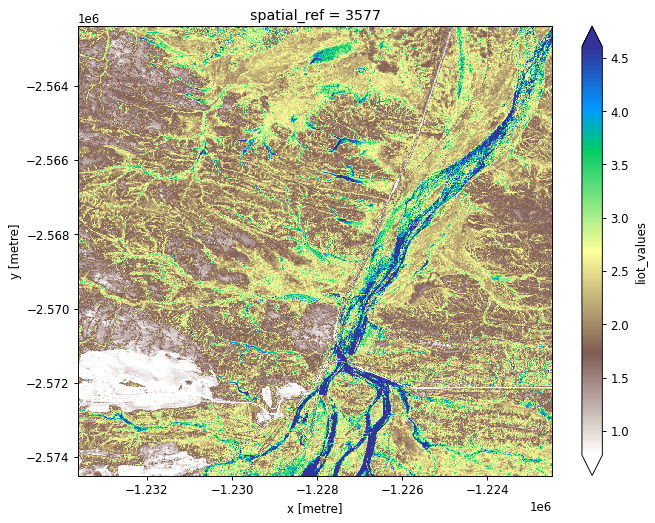

In [17]:
# set the metric you want to view (e.g. pos_values, pos_times, vos_values, vos_times, ect.)
metric_name = 'liot_values'

# create fig
fig = plt.figure(figsize=(9, 7), dpi=85)

# plot this on map
ds_phenos[metric_name].plot(robust=True, cmap='terrain_r')